In [ ]:
!nvidia-smi
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

In [67]:
# !nvidia-smi
!python3 main.py

  File "main.py", line 81
    %matplotlib inline
    ^
SyntaxError: invalid syntax


In [72]:
import torch
import random
import numpy as np

def fix(env, seed):
    env.seed(seed)
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    # torch.set_deterministic(True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [73]:
import torch.nn as nn

config = {
    "common_optim_hparas": {
        "lr": 0.0001,  # base learning rate
        "weight_decay": 1e-5,  # optional while using Adam
        # "momentum": 0.5,  only needs when using SGD
    },
    "actor_optimizer": "Adam",
    "actor_optim_hparas": {
        "lr": 0.0001,  # needs to be modified, can be different with base learning rate
        "weight_decay": 1e-5,  # optional while using Adam
        # "momentum": 0.5,  only needs when using SGD
    },
    "critic_optimizer": "Adam",
    "critic_optim_hparas":{
        "lr": 0.0001,  # needs to be modified, can be different with base learning rate
        "weight_decay": 1e-5,  # optional while using Adam
        # "momentum": 0.5,  only needs when using SGD
    },
    "common_network": nn.Sequential(
        # implement common network model
        # the last layer has the same dimension with actor network and critic network
        # the first layer dimension can be seen by calling env.observation_space
        nn.Linear(8, 16), 
        nn.Linear(16, 16), 
        nn.Linear(16, 32)
        
    ),
    "actor_network": nn.Sequential(
        # implement actor network model
        # actor is a classifier network
        # the last layer dimension can be seen by calling env.action_space
        nn.Linear(32, 16),
        nn.Linear(16, 4),
        nn.Softmax(dim = -1)
    ),
    "critic_network": nn.Sequential(
        # implement critic network model
        # critic is a regression network
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 4),
        nn.ReLU(),
        nn.Linear(4, 1)
    ),
    "random_seed": 801,
    "batch_num": 10,  # times for actor, critic to renew
    "episode_per_batch": 5,  # the bigger the num is, the more training data can collect
    "test_episode_num": 5,  # times for testing the model
    "save": False,  # determine whether to save current model during trainig
    "save_per_batch": 10,  # save model while after num
    "save_path": "none",  # where to save
    "load": False,  # load model from previous progress
    "load_path": "none",  # load path
}

In [78]:
import torch.optim as optim
from torch.distributions import Categorical

class RLbase(nn.Module):
    def __init__(self) -> None:
        super(RLbase, self).__init__()
        self.base_network = config["common_network"]
        self.actor_network = config["actor_network"]
        self.critic_network = config["critic_network"]

    def get_device(self):
        return "cuda" if torch.cuda.is_available() else "cpu"
    
    def forward(self, state):
        x = self.base_network(state)
        return self.actor_network(x), self.critic_network(x)

    def get_actor_parameters(self):
        return [
            {"params": self.base_network.parameters()},
            {"params": self.actor_network.parameters(), **config["actor_optim_hparas"]}
        ]

    def get_critic_parameters(self):
        return [
            {"params": self.base_network.parameters()},
            {"params": self.critic_network.parameters(), **config["critic_optim_hparas"]}
        ]

    def save(self, batch, PATH):
        torch.save({
            "batch": batch
        }, PATH)
    
    def load(self, PATH):
        checkpoint = torch.load(PATH)
        return checkpoint["batch"]

class Actor():
    def __init__(self, base) -> None:
        self.network = base
        self.optimizer = getattr(optim, config["actor_optimizer"])(base.get_actor_parameters(), **config["common_optim_hparas"])
        
    def forward(self, state):
        x, _ = self.network(torch.FloatTensor(state).to(self.network.get_device()))
        return x

    def sample(self, state):  # may add randomness to sampling
        action_prop = self.forward(state)
        action_dist = Categorical(action_prop)
        action = action_dist.sample()
        return action.item(), action_dist.log_prob(action)

    def learn(self, log_probs, benefit_degrees):
        loss = (-log_probs * benefit_degrees).sum().requires_grad_()  # may use other definition, unsure about whether to add a "-" before calculating
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()

    def save(self, PATH):
        torch.save({
            "actor_network": self.network.state_dict(),
            "actor_optimizer": self.optimizer.state_dict()
        }, PATH)

    def load(self, PATH):
        checkpoint = torch.load(PATH)
        self.network.load_state_dict(checkpoint["actor_network"])
        self.optimizer.load_state_dict(checkpoint["actor_optimizer"])

class Critic():
    def __init__(self, base) -> None:
        self.network = base
        self.optimizer = getattr(optim, config["critic_optimizer"])(base.get_critic_parameters(), **config["common_optim_hparas"])

    def forward(self, state):
        _, x = self.network(torch.FloatTensor(state).to(self.network.get_device()))
        return x

    def learn(self, benefit_degrees):
        loss = (benefit_degrees * benefit_degrees).sum().requires_grad_()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def save(self, PATH):
        torch.save({
            "critic_network": self.network.state_dict(),
            "critic_optimizer": self.optimizer.state_dict()
        }, PATH)

    def load(self, PATH):
        checkpoint = torch.load(PATH)
        self.network.load_state_dict(checkpoint["critic_network"])
        self.optimizer.load_state_dict(checkpoint["critic_optimizer"])

  0%|          | 0/10 [00:00<?, ?it/s]

Random seed: 801
Device: cuda


Total: -282.2, Final: -100.0:   0%|          | 0/10 [00:01<?, ?it/s]


benefit degrees looks like  (469,)
cross log_probs looks like  (469,)


Total: -142.6, Final: -100.0:  10%|█         | 1/10 [00:03<00:18,  2.07s/it]


benefit degrees looks like  (396,)
cross log_probs looks like  (396,)


Total: -106.9, Final: -100.0:  20%|██        | 2/10 [00:05<00:15,  1.97s/it]


benefit degrees looks like  (493,)
cross log_probs looks like  (493,)


Total: -182.0, Final: -100.0:  30%|███       | 3/10 [00:07<00:14,  2.05s/it]


benefit degrees looks like  (513,)
cross log_probs looks like  (513,)


Total: -198.7, Final: -100.0:  40%|████      | 4/10 [00:10<00:12,  2.12s/it]


benefit degrees looks like  (575,)
cross log_probs looks like  (575,)


Total: -187.6, Final: -100.0:  50%|█████     | 5/10 [00:12<00:11,  2.25s/it]


benefit degrees looks like  (513,)
cross log_probs looks like  (513,)


Total: -206.6, Final: -100.0:  60%|██████    | 6/10 [00:14<00:09,  2.27s/it]


benefit degrees looks like  (468,)
cross log_probs looks like  (468,)


Total: -171.6, Final: -100.0:  70%|███████   | 7/10 [00:17<00:06,  2.22s/it]


benefit degrees looks like  (473,)
cross log_probs looks like  (473,)


Total: -173.4, Final: -100.0:  80%|████████  | 8/10 [00:18<00:04,  2.18s/it]


benefit degrees looks like  (420,)
cross log_probs looks like  (420,)


Total: -207.3, Final: -100.0:  90%|█████████ | 9/10 [00:20<00:02,  2.09s/it]


benefit degrees looks like  (426,)
cross log_probs looks like  (426,)


Total: -207.3, Final: -100.0: 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


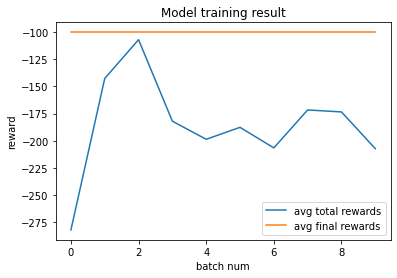

Total reward:  68.0, Num of action: 1000
Total reward: -62.7, Num of action: 114
Total reward: -203.3, Num of action: 98
Total reward: -130.1, Num of action: 107
Total reward: -82.6, Num of action: 80
Model average reward when testing for 5 times is: -82.14
Action distribution:  {3: 339, 2: 369, 0: 350, 1: 341}


In [81]:
import gym
from tqdm import tqdm
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

class Main():
    def __init__(self) -> None:
        self.env = gym.make("LunarLander-v2")
        self.base = RLbase()
        self.actor = Actor(self.base)
        self.critic = Critic(self.base)
        self.device = self.base.get_device()

    def __set_environment(self):
        print(f'Random seed: {config["random_seed"]}')
        fix(env=self.env, seed=config["random_seed"])
        self.env.reset()
        print(f"Device: {self.device}")

    def __training(self):
        start_batch = 0
        if config["load"]:
            start_batch = self.base.load(config["load_path"])
            self.actor.load(config["load_path"])
            self.critic.load(config["load_path"])

        self.base.to(self.device)
        # implement Reinforcement Learning training algorithm
        self.actor.network.train()
        self.critic.network.train()

        avg_total_rewards, avg_final_rewards = [], []
        progress_bar = tqdm(range(start_batch, config["batch_num"]))
        for batch in progress_bar:
            log_probs, benefit_degrees = [], []  # log_probs stores e_n, benefit_degrees stores A_n
            total_rewards, final_rewards = [], []  # total_rewards stores the total reward of the whole sequence, final_rewards stores the reward while finishing an episode(check to see if landing success)
            # collecting training data
            for episode in range(config["episode_per_batch"]):
                # state = torch.tensor(self.env.reset()).to(self.device)
                state = self.env.reset()
                total_reward, total_step = 0, 0
                while True:
                    action, log_prob = self.actor.sample(state)
                    next_state, reward, done, _ = self.env.step(action)

                    bd = reward + self.critic.forward(next_state).detach().cpu() - self.critic.forward(state).detach().cpu()  # implements Advantage actor-critic
                    benefit_degrees.append(bd)
                    log_probs.append(log_prob)
                    state = next_state
                    total_reward += reward
                    total_step += 1
                    if done:
                        final_rewards.append(reward)
                        total_rewards.append(total_reward)
                        break
            print(f"\nbenefit degrees looks like ", np.shape(benefit_degrees))  
            print(f"cross log_probs looks like ", np.shape(log_probs))

            # record training process
            avg_total_rewards.append(sum(total_rewards) / len(total_rewards))
            avg_final_rewards.append(sum(final_rewards) / len(final_rewards))
            progress_bar.set_description(f"Total: {avg_total_rewards[-1]: 4.1f}, Final: {avg_final_rewards[-1]: 4.1f}")
            # renew actor and critic
            log_probs = torch.stack(log_probs).to(self.device)
            benefit_degrees = torch.stack(benefit_degrees).to(self.device)
            benefit_degrees = (benefit_degrees - benefit_degrees.mean(dim=0, keepdim=True)) / (benefit_degrees.std(dim=0, keepdim=True) + 1e-9)  # standarize benefit degrees
            self.actor.learn(log_probs, benefit_degrees)
            self.critic.learn(benefit_degrees)
            # save model if needed
            if config["save"] and batch % config["save_per_batch"] == 0:
                self.base.save(batch, config["save_path"])
                self.actor.save(config["save_path"])
                self.critic.save(config["save_path"])
        return avg_total_rewards, avg_final_rewards

    def __get_trainig_result(self, avg_total_rewards, avg_final_rewards):
        plt.figure()
        plt.plot(avg_total_rewards, label="avg total rewards")
        plt.plot(avg_final_rewards, label="avg final rewards")
        plt.legend()
        plt.xlabel("batch num")
        plt.ylabel("reward")
        plt.title("Model training result")
        plt.show()

    def __test_model(self):
        fix(self.env, config["random_seed"])
        self.actor.network.eval()
        # self.critic.network.eval()
        avg_reward = 0
        action_distribution = {}
        for test_episode in range(config["test_episode_num"]):
            action_num, total_reward = 0, 0
            state = self.env.reset()
            done = False
            while not done:
                action, _ = self.actor.sample(state)
                if action not in action_distribution.keys():
                    action_distribution[action] = 1
                else:
                    action_distribution[action] += 1
                
                state, reward, done, _ = self.env.step(action)
                total_reward += reward
                action_num += 1
            print(f"Total reward: {total_reward: 4.1f}, Num of action: {action_num}")
            avg_reward += total_reward

        avg_reward = avg_reward / config["test_episode_num"]
        print(f"Model average reward when testing for {config['test_episode_num']} times is: %.2f"%avg_reward)
        print("Action distribution: ", action_distribution)

    def main(self):
        # TODO: Finish main function
        self.__set_environment()
        avg_total_rewards, avg_final_rewards = self.__training()
        self.__get_trainig_result(avg_total_rewards, avg_final_rewards)
        self.__test_model()


if __name__ == "__main__":
    Main().main()